# ASP3231 Assignment 1 2022

# Due 5pm Tuesday 12 April

# Don't forget conda activate obsastro2022 and import the libraries that you need

# Please put your name and student number here

In [1305]:
# Cedric Liang
# 29674662



# CCD images


# Q1a) Data for the projects is available via Moodle. For the night you observed download an example of a raw bias, raw dark, raw R-band flat field and raw R-band science image into this notebook. Choose images where the final digit of file number corresponds to the final digit of your student number.

# (If you have yet to observe, download a C11 image from 26 March 2022.)


# 4 marks

In [1306]:
import warnings
import os
import numpy as np
import astropy
import ccdproc
from ccdproc import CCDData, Combiner
from astropy import units as u
from astropy.visualization import SqrtStretch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from photutils.centroids import centroid_com, centroid_1dg, centroid_2dg
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import Background2D
from photutils import MedianBackground
from scipy.ndimage import shift
import functools
import operator
import gc
gc.enable()

warnings.filterwarnings('ignore')
ROOT_PATH = os.path.normpath(os.getcwd())

plt.rcParams['figure.figsize'] = [15, 15]

# Code below for copy pasting - if you see this I forgot to take it out.

# proc_files = {band: ccdproc.ImageFileCollection(
#     f"{ROOT_PATH}/src/processed_ims/", glob_include=f"proc_NGC_3293_{band}*") for band in BANDS}

# scim = {
#     band: [CCDData.read(f"{ROOT_PATH}/src/processed_ims/{fn}")
#            for fn in image_files.files_filtered(PICTTYPE = 1)]
#     for band, image_files
#     in proc_files.items()}


In [1307]:
bias_files = ccdproc.ImageFileCollection(
    f"{ROOT_PATH}/", glob_include="Bias_*")

bias_image = [CCDData.read(f"{ROOT_PATH}/{fn}", unit="adu")
              for fn in bias_files.files_filtered(PICTTYPE=2)][0]

# print(bias_image)


# Q1b) Measure the statistics for the bias image. What is the noise, and how can you check it isn't being biased by a small number of outlier pixels?

# 4 marks

In [1308]:
# function to return a dict of flat stats, given an image
def image_stats(image):
    return {
        'Min': np.min(image),
        'Max': np.max(image),
        'Mean': np.mean(image),
        'Mdn': np.median(image),
        'Stdev': np.std(image)
    }

# A function that prints the stats, given a dict of image stats. Keeping these separate allows us to take the stats as variables if we need to use it programatically.


def print_stats(label: str, stats_dict):
    print("\n", label)
    for key, value in stats_dict.items():
        print("\t", key, "\t\t", value)


In [1309]:
print(bias_image.header["EXPTIME"])
print_stats("Bias statistics:", image_stats(bias_image))


0.0

 Bias statistics:
	 Min 		 1921
	 Max 		 2273
	 Mean 		 2084.668868475502
	 Mdn 		 2084.0
	 Stdev 		 33.34850952312581


Here the noise is about expected - quite good actually. The standard deviation is lower than the order of the square root of the mean. We know we're not being biased by a small number of outliers because the minimum maximum range is quite tight, so this is a good bias to use.

# Q1c) For a region of the science image with no stars, measure the statisics. Using these numbers and the numbers for the bias, do you believe the noise in the science image is dominated by read noise, sky background noise or is (roughly) evenly split between the two?

# 6 marks

In [1310]:
science_files = ccdproc.ImageFileCollection(
    f"{ROOT_PATH}/", glob_include="NGC_*")

science_image = [CCDData.read(f"{ROOT_PATH}/{fn}", unit="adu")
                 for fn in science_files.files_filtered(PICTTYPE=1)][0]

# print(science_image)


Let's use DS9 to find a subregion of the image with no stars - this isn't easy as this object is a globular cluster in a bright star-producing region. The box defined by the corners 
- (213, 995)
- (295, 922) 

will do.

In [1311]:
subregion = science_image[922:995, 213:295]

print(subregion)


[[2149 2158 2119 ... 2179 2229 2251]
 [2219 2189 2222 ... 2119 2207 2152]
 [2164 2220 2156 ... 2220 2120 2155]
 ...
 [2231 2172 2180 ... 2208 2193 2161]
 [2185 2193 2193 ... 2113 2162 2139]
 [2152 2154 2110 ... 2176 2156 2182]] adu


In [1312]:
# print(science_image.header["EXPTIME"])
print_stats("Science image subregion stats: ", image_stats(subregion))



 Science image subregion stats: 
	 Min 		 2068
	 Max 		 2308
	 Mean 		 2173.4096224523887
	 Mdn 		 2173.0
	 Stdev 		 33.40763532267407


The standard deviation is almost exactly the same as that of the bias image. The max is higher, understandably so, due to the possibility of hot pixels, background radiation, etc. Still, the statistics on this region of the science image are remarkably clean. As such, we can see that the contribution of the sky background noise isn't substantial at all compared to the underlying detector noise.

# Q1d) Measure statistics across the whole of the flat-field image, a small region with a dust donught and a small region without any obvious features. Interpret the different measurements of the standard deviation, explaining why they may differ from each other. 

# 9 marks (3 for the stats and 6 for the explanation)

In [1313]:
flat_files = ccdproc.ImageFileCollection(
    f"{ROOT_PATH}/", glob_include="Flat_*")

flat_image = [CCDData.read(f"{ROOT_PATH}/{fn}", unit="adu")
              for fn in flat_files.files_filtered(PICTTYPE=4)][0]

# print(flat_image)
print_stats("Entire flat field image stats: ", image_stats(flat_image))
# print(flat_image.header["EXPTIME"])

# dust donut subsection
dust_subregion = flat_image[464:481, 208:224]
print_stats("Dust donut stats: ", image_stats(dust_subregion))

plain_subregion = flat_image[529:580, 759:907]
print_stats("Plain subregion stats: ", image_stats(plain_subregion))



 Entire flat field image stats: 
	 Min 		 6359
	 Max 		 15923
	 Mean 		 13959.414819631944
	 Mdn 		 14056.0
	 Stdev 		 510.6726984031844

 Dust donut stats: 
	 Min 		 12949
	 Max 		 14883
	 Mean 		 13910.1875
	 Mdn 		 13967.0
	 Stdev 		 357.2980169718065

 Plain subregion stats: 
	 Min 		 13609
	 Max 		 14798
	 Mean 		 14211.252517223105
	 Mdn 		 14213.0
	 Stdev 		 160.4825496484783


We see here three different profiles of statistics. The plain subregion statistics understandibly has the lower standard deviation, but it also has the higest mean and median out of all the observations, as it does not have any structural components that obstruct the number of photons reaching the detector, as we would expect in the case of a dust donut.

The observation for the dust donut picture also matches what we would expect - the median is decreased compared to the plain subregion since less counts are being detected due to the shadow, and the presence of both obstructed components and unobstructed components (by virtue of being a ring) causes the standard deviation to be higher. Lower minimum, lower mean, higher standard deviation due to heterogeneity - it's about on par with what we expect.

The statistics for the entire flat field image are heavily skewed because of the presence of heavy vignetting in the top right hand corner of the image. This is a portion of the image where the ccd is either distorted, or physically obstructed by the shadow of the edge of the filter. We can see this manifest in the significantly lower minimum value.

The degree to which the presence of this vignetting increases the standard deviation from the mean seems to heavily outweight any benefit we get from observing more pixels, and this is to be expected. Clearly, a large number of very low counts in a select region of the image will cause the square root of the sum of the squares of the difference from the mean by definition to increase substantially.

On the other hand, we notice that the medians for both the dust donut and the whole image cases aren't as impacted as the means when comparing with the region without structures. This is to be expected - medians are worse when it comes to handling data that have highly disjoint/discontinuous distribution characteristics, but are better at eradicating substantial but continuous and non-overwhelming outliers like this.

# Stellar population models

# bc2003_hr_m62_salp_ssp.1ABmag (provided) gives the Bruzual & Charlot (2003) model ugriz photometry of a one Solar mass population of stars as it ages. Thus, to get the photometry for a billion Solar masses all the luminosities should be boosted by a factor of a billion.

# Q2a) Write code to read in this model data and print the ugriz photometry of a 10 billion year old population of stars. You may adapt code provided with the lecture notes to do this.

# 8 marks

In [1314]:
with open("bc2003_hr_m62_salp_ssp.1ABmag", "r") as f:
    lines = f.readlines()

# apply the split function to the lines - generator style for lazy evaluation to save memory
split_lines_bc2003 = (line.split() for line in lines if line[0] != "#")
column_labels_array = ["log-age-yr", "Mbol      ", "g_AB      ",
                       "(u-g)AB", "(g-r)AB", "(g-i)AB", "(g-z)AB"]

# convert the elements to float
raw_data_bc2003 = [[float(elem) for elem in line]
                   for line in split_lines_bc2003]

ten_bil_row = next(filter(lambda row: row[0] == float(10), raw_data_bc2003))

for idx, elem in enumerate(ten_bil_row):
    print(column_labels_array[idx], "\t", elem)


log-age-yr 	 10.0
Mbol       	 6.3857
g_AB       	 7.6662
(u-g)AB 	 1.8148
(g-r)AB 	 0.8358
(g-i)AB 	 1.2332
(g-z)AB 	 1.5456


# Q2b) Plot u-g colour as a function of stellar population age.

# 8 marks

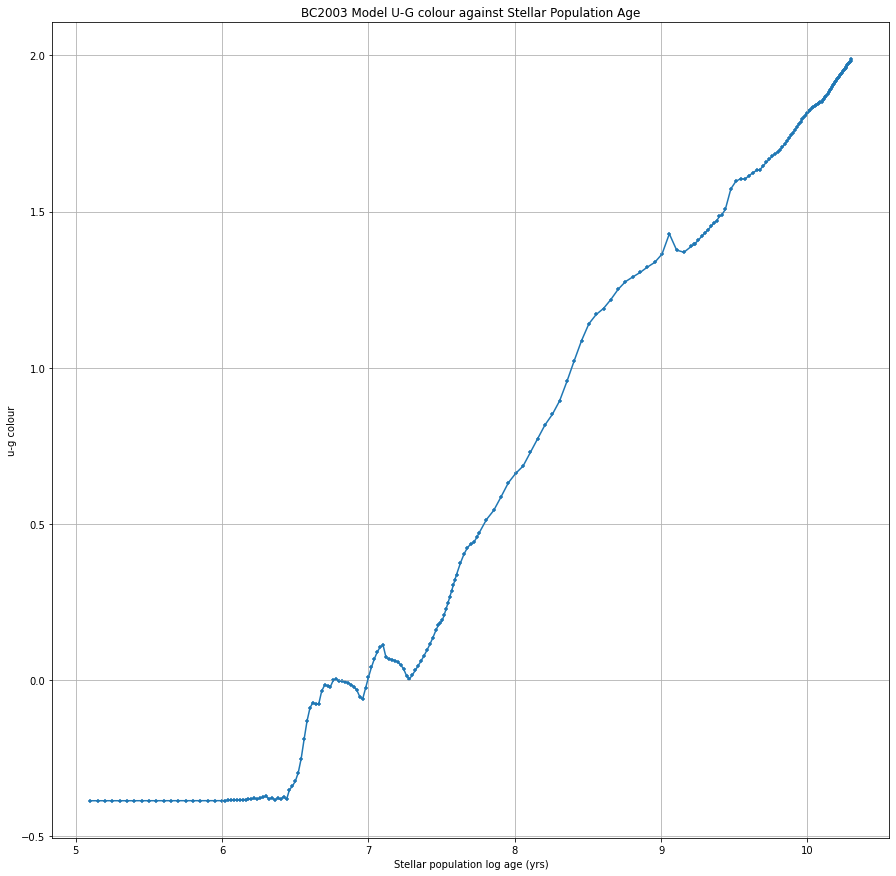

In [1315]:
u_min_gs = list(map(operator.itemgetter(3), raw_data_bc2003))
ages = list(map(operator.itemgetter(0), raw_data_bc2003))

plt.plot(ages, u_min_gs)
plt.scatter(ages, u_min_gs, marker="+", s=16)
plt.title("BC2003 Model U-G colour against Stellar Population Age")
plt.xlabel("Stellar population log age (yrs)")
plt.ylabel("u-g colour")
plt.grid(True)
plt.show()


<font color=blue> Figure 2a: U-G colour plotted against stellar population age. Smaller numerical values of u-g colour corresponds to bluer stars.

# Q2c) Use http://skyserver.sdss.org/dr15/en/tools/chart/navi.aspx to search the Sloan Digital Sky Survey for the following low redshift galaxy, based on the <I>second last digit</I> of your student number:

0 - NGC 3310<BR>
1 - NGC 7479<BR>
2 - Mrk 571<BR>
3 - NGC 880<BR>
4 - NGC 3690<BR>
5 - NGC 750<BR>
6 - NGC 1144<BR>
7 - NGC 4800<BR>
8 - NGC 4801<BR>
9 - NGC 4901<BR>
# Then click the explore option to look up your galaxy's photometry, and write this ugriz photometry down in this notebook.
    
# 5 marks

I select NGC 1144 for the digit 6 in my student number 29674662.

I have the following ugriz magnitudes:

16.23	14.16	13.15	12.63	12.19

# Q2d) Write code to determine the (luminosity weighted) stellar population of your galaxy, using the u-g colour.

# 12 marks

In [1316]:
ngc_1144_u_mag = 16.23
ngc_1144_g_mag = 14.16

ngc_u_min_g = ngc_1144_u_mag - ngc_1144_g_mag
print(ngc_u_min_g)

2.0700000000000003


Something doesn't match up here - if we use just the u-g value, we would have a colour that corresponds to an age that is well in excess of the age of the universe. Still, I'll use it to calculate a figure anyway.

[ 0.61732093 -4.33553578]


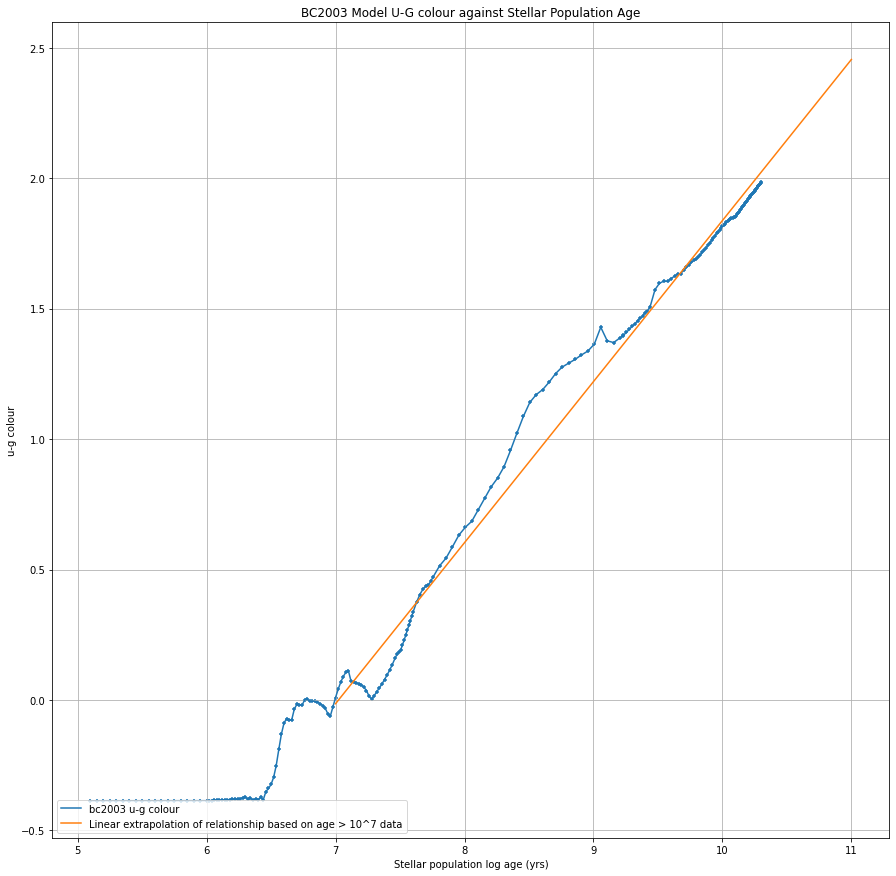

In [1317]:
# get index of first datapoint with age greater than 10^8 years.
idx_greater_ten_pow_eight = next(
            filter(lambda tup: tup[1] > 7, enumerate(ages))
        )[0]

# make linear fit with data points greater than 10^8
linfit_ages = ages[idx_greater_ten_pow_eight:]
linfit_u_min_gs = u_min_gs[idx_greater_ten_pow_eight:]

lin_fit = np.polyfit(linfit_ages, linfit_u_min_gs, 1)

print(lin_fit)
# generate points on linfit line
linfit_age_space = np.linspace(7, 11, 100)
linfit_u_min_g_space = linfit_age_space*lin_fit[0] + lin_fit[1]

plt.plot(ages, u_min_gs, label="bc2003 u-g colour")
plt.plot(linfit_age_space, linfit_u_min_g_space, label="Linear extrapolation of relationship based on age > 10^7 data")
plt.scatter(ages, u_min_gs, marker="+", s=16)
plt.title("BC2003 Model U-G colour against Stellar Population Age")
plt.xlabel("Stellar population log age (yrs)")
plt.ylabel("u-g colour")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

We can also derive our value of stellar population age from our linfit line:

In [1318]:
extrapolated_age = (ngc_u_min_g - lin_fit[1])/lin_fit[0]

print(10**extrapolated_age)

23787362805.24006


23 billion years! Clearly this model isn't sufficient for this galaxy.

# Q2e) Explain one assumption that could result in your stellar population age different from what it should be.

# 4 marks

We used a model for a 1 solar mass population of stars and applied it to a galaxy. We made the assumption that these two things are equivalent, but the radiation in this galaxy may not just come from its population of stars. This is especially true if we consider that we are using u-g values, and we know that there are certain galaxies that can be particularly emissive in the ultraviolet regime and shorter wavelengths.

Galaxies don't emit radiation like stars - there are other things like (for example) an AGN in an active galaxy that can contribute to high radiation counts.

Another consideration is the simple fact that galaxies consist of stars of a range of masses! We tried to fit a model of a population of stars with masses of 1 m_sol, but clearly, a galaxy would have a range of stars with a range of emission properties. Given that luminosity does NOT scale linearly with mass, this alone makes our model unsuitable for application at this scale.

# Q2f) If the Sun has a g-band absolute magnitude of 5.11, what is the mass to light ratio of your best fit model?

# 6 marks

We make a few notes - we normalise the mass to light ratio to be in solar terms. The position of the sun in the data sheet is approximately at 10^8.97 (I'm not sure why this doesn't fit the known age of the sun, but I won't question it).

Let's call it 10^9 years. We can note that this is a place where the mass-to-light ratio is 1.

We expect M to scale proportional to t to the power -0.36, and L to scale proportional to t to the power -0.9.

In [1319]:
factor_age_change = 10**extrapolated_age/10**9

factor_m_change = factor_age_change**(-0.36)
factor_l_change = factor_age_change**(-0.9)

print(factor_m_change/factor_l_change)
print(np.log10(factor_m_change/factor_l_change))

5.536394137556782
0.7432270001035048


As such, we would have expected our model to reach a mass to light ratio of about 5.54 times that of the Sun, or 10^0.74.

# Q3a) Open the data from Park & Lee (1999) for NGC 2192 (taken from https://webda.physics.muni.cz) - park.txt - and use python and Jupyter to ingest this photometry. 

# Use print to some values are being read correctly by your code.

# 8 marks

In [1320]:
with open("park.txt", "r") as f:
    lines = f.readlines()[3:]

# apply the split function to the lines
split_lines = (line.split() for line in lines)

# convert the elements to float
# we see weird outliers with colour values of 9.99 - not sure what they are but they greatly skew my plot and are clearly not main seq objects so I filter them out
float_lines = list(filter(lambda line: 9.99 not in line,
                          [[float(elem) for elem in line] for line in split_lines]))

print("ID 1 expected:",
      "1  469.4  859.0 15.865  0.477  0.099  0.482 0.013 0.030 0.058 0.014")
print("ID 1 actual:", float_lines[0])
print("ID 5 expected:",
      "5 537.5  891.7 12.969  0.924  0.475  0.930 0.002 0.006 0.010 0.002")
print("ID 5 actual:", float_lines[4])


ID 1 expected: 1  469.4  859.0 15.865  0.477  0.099  0.482 0.013 0.030 0.058 0.014
ID 1 actual: [1.0, 469.4, 859.0, 15.865, 0.477, 0.099, 0.482, 0.013, 0.03, 0.058, 0.014]
ID 5 expected: 5 537.5  891.7 12.969  0.924  0.475  0.930 0.002 0.006 0.010 0.002
ID 5 actual: [5.0, 537.5, 891.7, 12.969, 0.924, 0.475, 0.93, 0.002, 0.006, 0.01, 0.002]


# Q3a) Plot the V-band magnitude as a function of B-V colour for NGC 2192 using the Park & Lee (1999) data. Remember to choose your axes so it looks like an HR diagram.

# 8 marks

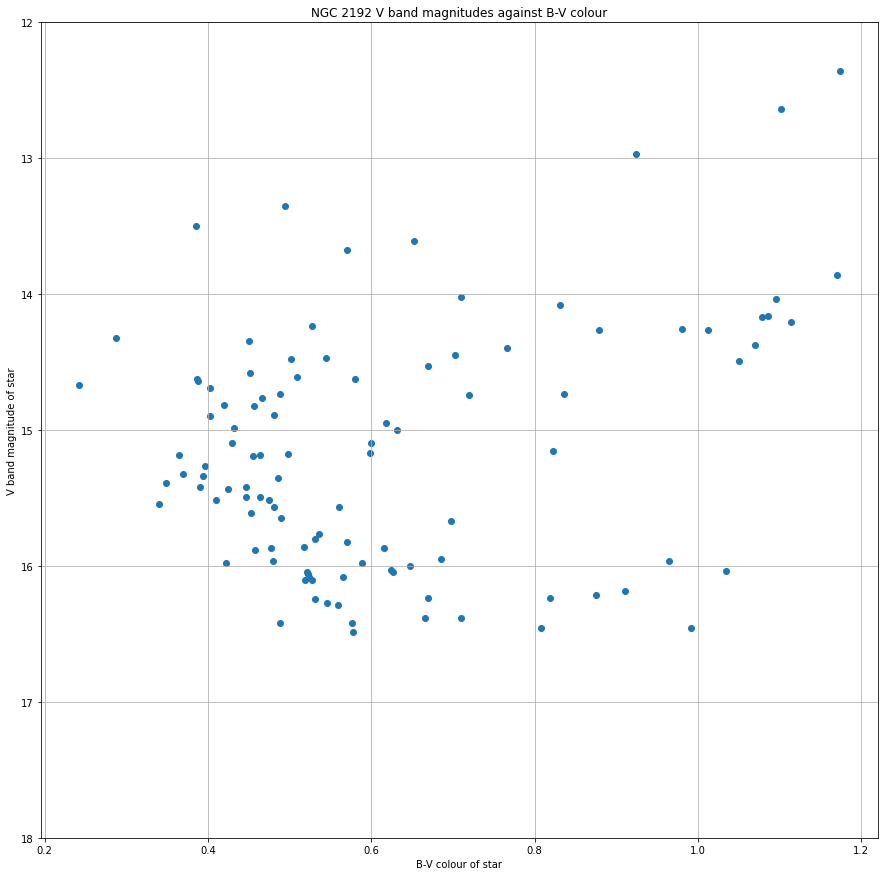

In [1321]:
# get the relevant index
b_min_vs = [row[4] for row in float_lines]
vs = [row[3] for row in float_lines]


plt.scatter(b_min_vs, vs)
plt.ylim(18, 12)
plt.xlabel("B-V colour of star")
plt.ylabel("V band magnitude of star")
plt.title("NGC 2192 V band magnitudes against B-V colour")
plt.grid(True)
plt.show()


<font color=blue> Figure 1: B-V colour of stars in NGC 2192 plotted against their V band magnitudes. Note that these axes correspond to/are a proxy for the same relatioship in the context of a H-R diagram.

# Q3b) Generate a Girardi isochrone using http://stev.oapd.inaf.it/cgi-bin/cmd for an age corresponding to the last digit of your student number multiplied by 100 Myr plus 100 Myr (i.e. last digit of 3 corrresponds to 400 Myr).

# Then use python and Jupyter to ingest this isochrone and then plot V -band absolute magnitude as a function of B − V colour. 

# Hint: see the lectures and supplementary files presented with lecture slides. Also check that your first set of UBVRI photometry agrees with the first line in the relevant text file using print.


# 12 marks

In [1322]:
# My age is 300 Myr for a student number ending in 2.

with open("girardi_isochrone_300Myr.dat", "r") as f:
    isochrone_lines = [line for line in f.readlines() if line[0] != "#"]

split_lines_iso = map(lambda line: line.split(), isochrone_lines)
# note here the array slicing of elem 16 ensures that we don't try to convert the strings marking stages that appears in some of the lines into floats
float_lines_iso = [
    [float(col) for col in l[:16]]
    for l in split_lines_iso]

print("Expected first line:",
      "8.48	0.15000001	0.1500	-2.4957	3.5240	5.1517	11.009	15.939	14.432	12.848	11.740	10.426	9.205	8.651	8.402	1.96093953")
print("Actual first line:", float_lines_iso[0])


Expected first line: 8.48	0.15000001	0.1500	-2.4957	3.5240	5.1517	11.009	15.939	14.432	12.848	11.740	10.426	9.205	8.651	8.402	1.96093953
Actual first line: [8.48, 0.15000001, 0.15, -2.4957, 3.524, 5.1517, 11.009, 15.939, 14.432, 12.848, 11.74, 10.426, 9.205, 8.651, 8.402, 1.96093953]


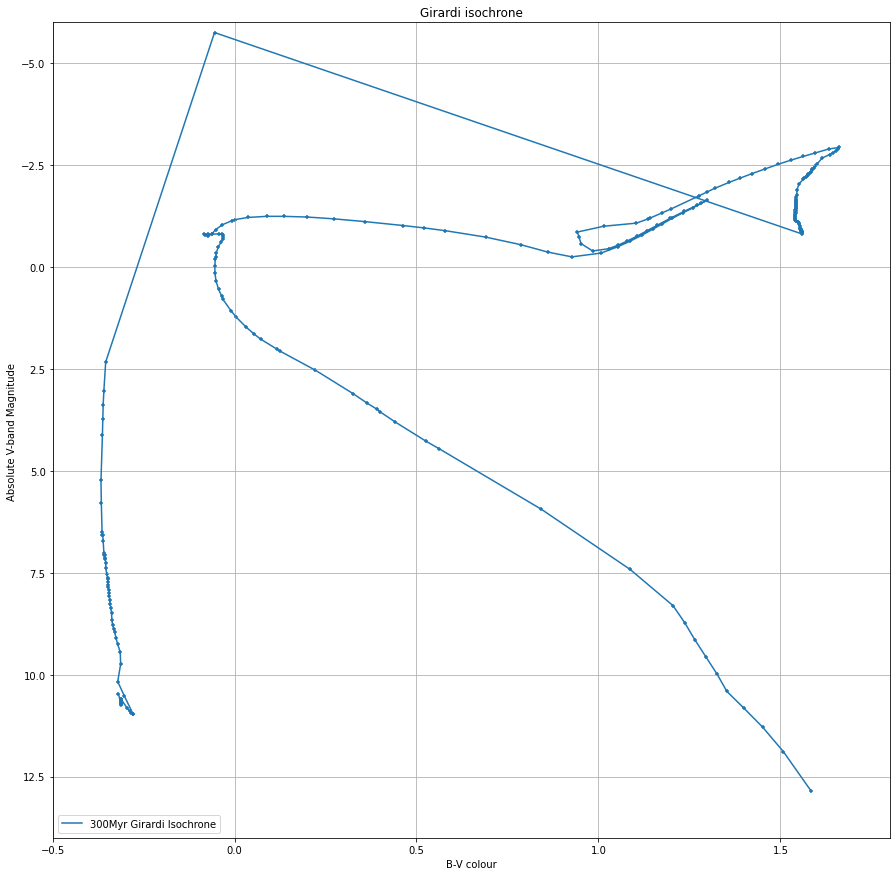

In [1323]:
# some nice list comprehension and function mapping to produce our b-v array
iso_vs = [row[9] for row in float_lines_iso]
iso_bs = [row[8] for row in float_lines_iso]

iso_b_min_vs = list(map(operator.sub, iso_bs, iso_vs))

# print(iso_b_min_vs)

plt.rcParams['figure.figsize'] = [15, 15]
plt.axis([-0.5, 1.8, 14, -6.0])
plt.scatter(iso_b_min_vs, iso_vs, marker="+", s=16)
plt.plot(iso_b_min_vs, iso_vs, label="300Myr Girardi Isochrone")
plt.xlabel('B-V colour')
plt.ylabel('Absolute V-band Magnitude ')
plt.title('Girardi isochrone')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


<font color=blue> Figure 2: Girardi Isochrone of 300 Myr. We start in the bottom right corner for low initial masses, then traverse up (brighter) and to the left (bluer) as we increase our initial mass. 

We can clearly see the effect that increasing initial mass has on the star's lifespan, as we begin to see stars that have already traversed onto the giant branches. The point at the tip of the asymptotic branch is from a star with initial mass M = 3.49848485 msol, and the very next data point is the traversal of the post-AGB stage all the way across to the single data point with magnitude of beyond -5, which resulted from a star with initial mass M = 3.49848580 msol. 

The sparsity of the data points in this post-AGB region indicates the extreme brevity of this stage of the star's life - even though the isochrone simulation is reducing the step size of M_init in this region substantially in an attempt to provide us with more data!

# Q3c) Offset the Giradi isochrone vertically (i.e. apply a distance modulus), so the Girardi isochrone matches the NGC 2192 main sequence. (For now just use a visual match, but more sophisticated methods of matching are possible.) Use the resulting offset to determine the distance modulus and distance to Coma star cluster. How does your distance compare with recent values from the literature?

# Hint - the top-left of the NGC 2192 sequence is easier to spot than the bottom right, where foreground/background stars complicate the picture.

# 11 marks

Let's apply an offset to see how that impacts our plot.

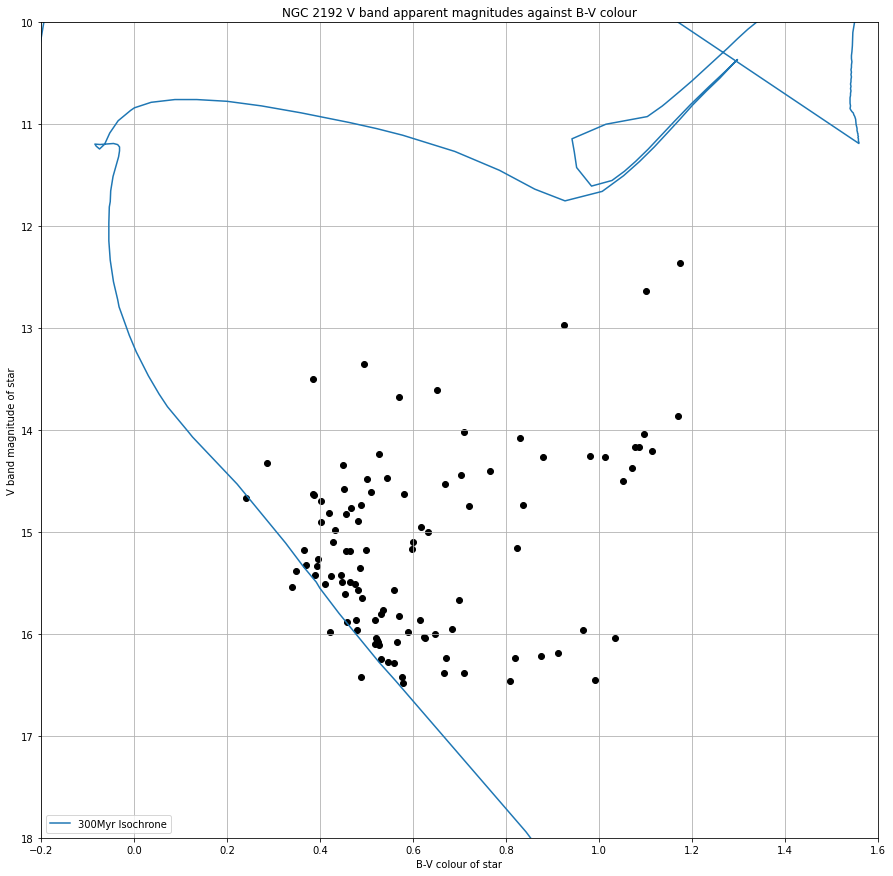

In [1324]:
offset = 12.0

plt.plot(iso_b_min_vs, [elem + offset for elem in iso_vs], label="300Myr Isochrone")
plt.scatter(b_min_vs, vs, c="black")
plt.xlim(-0.2, 1.6)
plt.ylim(18, 10)
plt.xlabel("B-V colour of star")
plt.ylabel("V band magnitude of star")
plt.title(
    "NGC 2192 V band apparent magnitudes against B-V colour")
plt.grid(True)
plt.legend(loc='lower left')

plt.show()


<font color=blue> Figure 3: Girardi Isochrone of 300 Myr overlaid on HR-diagram of stars in NGC 2192.

We don't have the greatest match in the world for this particular isochrone, but it's not too big of a deal.

Given we had to apply a distance modulus of 12, we can calculate the distance to the cluster as given by:

In [1325]:
d = 10*1.585**(offset)

print(f"Distance is {d} parsecs")


Distance is 2513.918527092279 parsecs


This is a bit off compared to the literature value given by Park and Lee (1999) of 3.5 kpc - but it's the right order of magnitude.


# Q3d) NGC 2192 has foreground dust extinction of E(B-V) = 0.20, so the B-V colours have been reddened by 0.20 magnitudes and the V-band apparent magnitudes are 0.62 fainter than they would be otherwise. Redo your distance estimate including this information.

# 6 marks

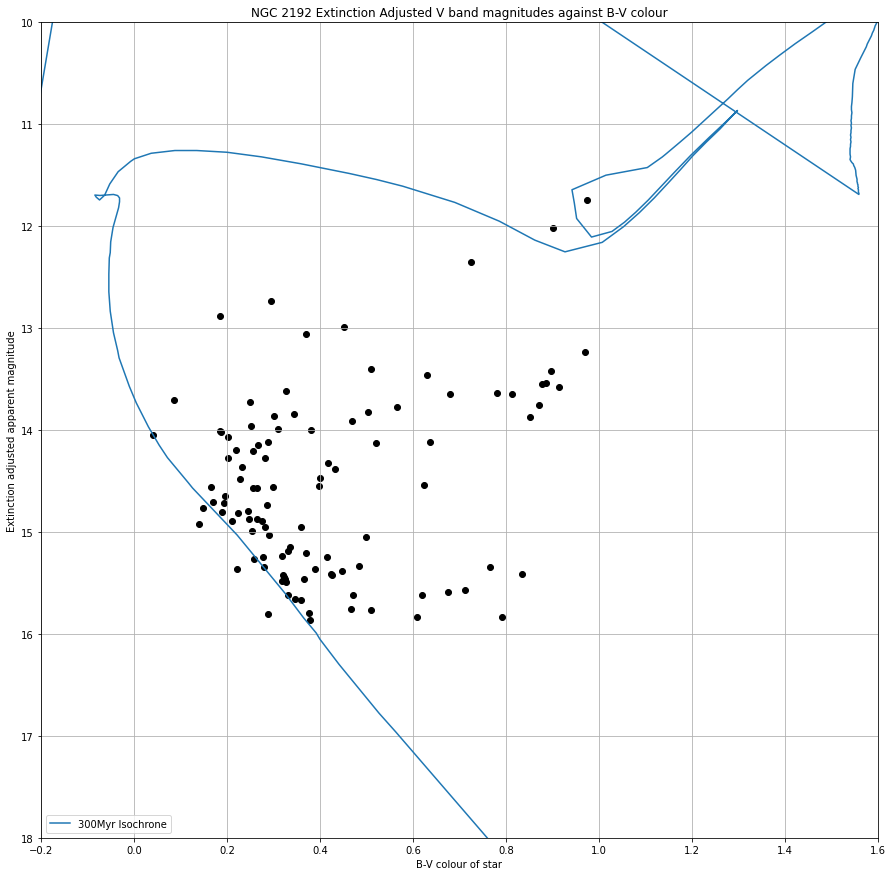

Distance is 3164.942555870428 parsecs


In [1326]:
# Let's shift our data
dust_extinction_abs_mag_v = 0.62
b_v_extinction = 0.20

adjusted_b_min_vs = [elem - b_v_extinction for elem in b_min_vs]
adjusted_vs = [elem - dust_extinction_abs_mag_v for elem in vs]


# Now we adjust this offset until we get a better match.
offset = 12.5

plt.plot(iso_b_min_vs, [elem + offset for elem in iso_vs], label="300Myr Isochrone")
plt.scatter(adjusted_b_min_vs, adjusted_vs, c="black")
plt.xlim(-0.2, 1.6)
plt.ylim(18, 10)
plt.xlabel("B-V colour of star")
plt.ylabel("Extinction adjusted apparent magnitude")
plt.title(
    "NGC 2192 Extinction Adjusted V band magnitudes against B-V colour")
plt.legend(loc='lower left')
plt.grid(True)
plt.show()

d = 10*1.585**(offset)

print(f"Distance is {d} parsecs")


<font color=blue> Figure 4: Girardi Isochrone of 300 Myr overlaid on HR-diagram of stars in NGC 2192. An colour adjustment of E(B-V) = 0.20 and a magnitude adjustment of 0.62 has been made to account for foreground extinction - note that the curve of the isochrone fits much more nicely with the data on hand, and we are able to define a more meaningful offset.

This new value that we've calculated is a lot closer to the previous literature value of 3.5 kpc! We still don't have the most fitting isochrone, but all that means is that our age estimate isn't the best, and there's a bit of human fitting judgement range when it comes to what constitutes an appropriate offset. We could probably do a lot better if we used a range of isochrones.

# Q3e) Generate Giradi isochrones for several specific ages, and use these to estimate the approximate age of NGC 2192 by overplotting the (offset) isochrones on the observed apparent V -band magnitude as a function of B − V colour. An age within a factor of two of the correct answer will suffice.

# 10 marks

Since we're making a distance estimate, let's use an offset that corresponds to the literature value of the distance.

In [1327]:
offset = 12.719
d = 10*1.585**(offset)

print(f"Distance is {d} parsecs")


Distance is 3500.8398289230086 parsecs


In [1328]:
ages = ["300Myr", "500Myr", "800Myr", "1Gyr", "1500Myr", "2Gyr"]
isochrone_data = []
for age in ages:
    with open(f"girardi_isochrone_{age}.dat", "r") as f:
        isochrone_lines = f.readlines()[12:]
        split_lines_iso = map(lambda line: line.split(), isochrone_lines)
        float_lines_iso = [
            [float(col) for col in l[:16]]
            for l in split_lines_iso]

        # index of first elem in list that is post-agb - this would be the brightest point (lowest magnitude number)
        # note that the row[9] for row part gets our v band magnitudes
        idx_post_agb = min(
            enumerate(row[9] for row in float_lines_iso), key=operator.itemgetter(1)
        )[0]

        # only append data up to that index
        isochrone_data.append((age, float_lines_iso[:idx_post_agb]))

print("First line of 300 Myr isochrone: ",
      isochrone_data[0][0], isochrone_data[0][1][0])
print("First line of 1 Gyr isochrone: ",
      isochrone_data[3][0], isochrone_data[3][1][0])


First line of 300 Myr isochrone:  300Myr [8.48, 0.15000001, 0.15, -2.4957, 3.524, 5.1517, 11.009, 15.939, 14.432, 12.848, 11.74, 10.426, 9.205, 8.651, 8.402, 1.96093953]
First line of 1 Gyr isochrone:  1Gyr [9.0, 0.15000001, 0.15, -2.495, 3.5241, 5.1514, 11.008, 15.935, 14.429, 12.845, 11.738, 10.424, 9.203, 8.65, 8.401, 1.96093953]


Now let's plot our Girardi isochrones:

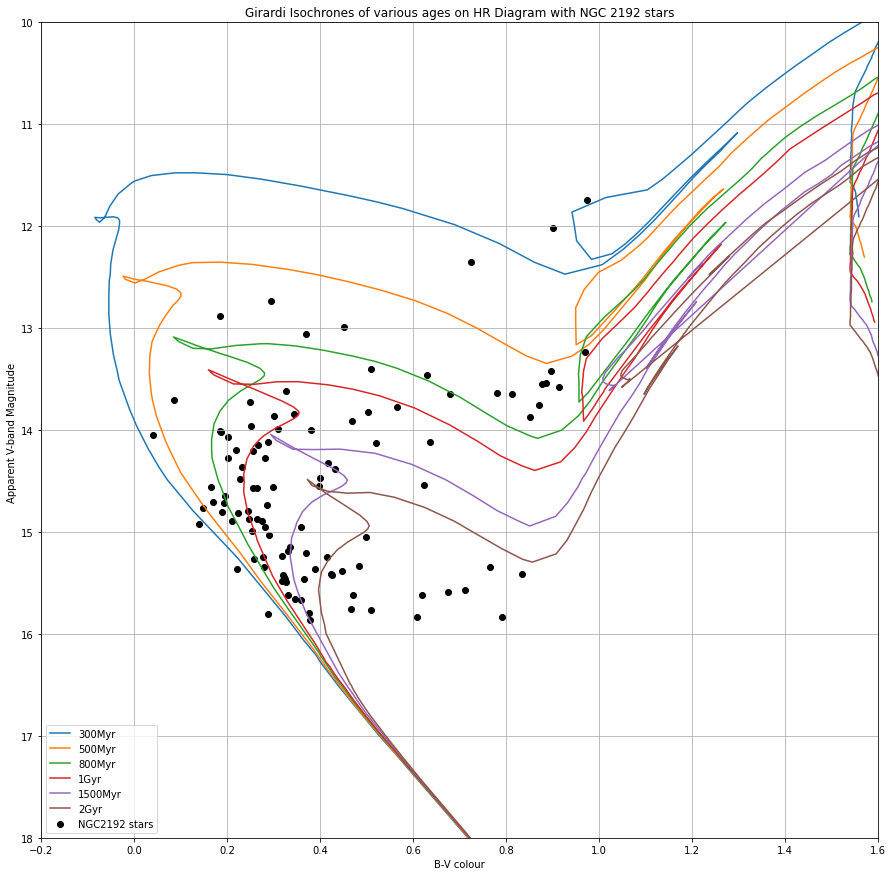

In [1329]:
plt.xlim(-0.2, 1.6)
plt.ylim(18, 10)
plt.xlabel('B-V colour')
plt.ylabel('Apparent V-band Magnitude ')
plt.title('Girardi Isochrones of various ages on HR Diagram with NGC 2192 stars')
plt.rcParams['figure.figsize'] = [15, 15]
plt.grid(True)

for isochrone in isochrone_data:
    iso_vs = [row[9] for row in isochrone[1]]
    iso_bs = [row[8] for row in isochrone[1]]

    # map subtraction over bs and vs, generating list of b-vs
    iso_b_min_vs = list(map(operator.sub, iso_bs, iso_vs))
    plt.plot(iso_b_min_vs, [elem + offset for elem in iso_vs], label=isochrone[0])

plt.scatter(adjusted_b_min_vs, adjusted_vs, label="NGC2192 stars", c="black")
plt.legend(loc='lower left')
plt.show()


<font color=blue> Figure 5: Girardi Isochrones of various ages plotted over data of NGC2192 stars. Note that we now have effectively two guidelines/constraints for our two degrees of freedom, and as such can make a much more accurate fit.

Based on inspection, an age of ~0.8-1Gyr can be estimated.

Here, we can see a collection of ages. The good thing compared to the fits we were trying to do before is that we have constraints on both our 'degrees of freedom'.If we are to look strictly at the main sequence stars for which we expect have the most data, we can see that our best fit happens somewhere around an age of 0.8 Gyr and 1 Gyr - so that is my estimate.

Indeed, this corresponds well with the literature value given in Park and Lee (1999), which was 1.1 plusminus 0.1 Gyr.

# Q3f) Identify a star where the ID matches the last two digits of your student number. Print out the ID, B-V colour and V-band magnitude. 

# Given the star's location on the HR diagram, do you believe it is a main sequence star, giant star or a foreground/background star that is not in the cluster. Justify your answer.

# 7 marks

The last two digits of my student ID are 62, so I'll pick the star with ID 62, which corresponds with a list index of 61.

In [1330]:
star_line = float_lines[61]
star_adjusted_b_v = adjusted_b_min_vs[61]
star_adjusted_vs = adjusted_vs[61]
print("Raw star data from file: ", star_line)
print("Extinction adjusted b-v: ", star_adjusted_b_v)
print("Extinction adjusted vmag: ", star_adjusted_vs)

Raw star data from file:  [62.0, 279.5, 1142.7, 16.102, 0.519, 0.058, 0.572, 0.01, 0.029, 0.077, 0.012]
Extinction adjusted b-v:  0.319
Extinction adjusted vmag:  15.482000000000001


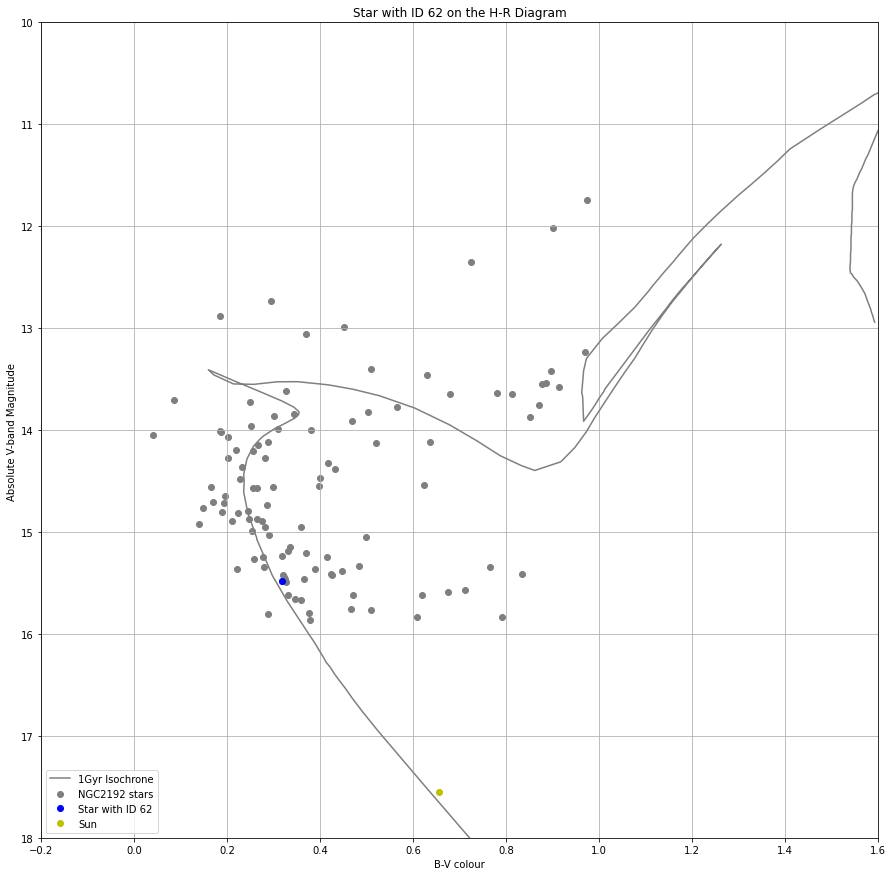

In [1331]:
plt.xlim(-0.2, 1.6)
plt.ylim(18, 10)
plt.xlabel('B-V colour')
plt.ylabel('Absolute V-band Magnitude ')
plt.title('Star with ID 62 on the H-R Diagram')
plt.rcParams['figure.figsize'] = [15, 15]
plt.grid(True)

# Grab the 1Gyr isochrone
isochrone = next(filter(lambda tup: tup[0] == "1Gyr", isochrone_data))

iso_vs = [row[9] for row in isochrone[1]]
iso_bs = [row[8] for row in isochrone[1]]

iso_b_min_vs = list(map(operator.sub, iso_bs, iso_vs))
plt.plot(iso_b_min_vs, [elem + offset for elem in iso_vs], label=f"{isochrone[0]} Isochrone", c="#7f7f7f")

plt.scatter(adjusted_b_min_vs, adjusted_vs, label="NGC2192 stars", c="#7f7f7f")
plt.plot(star_adjusted_b_v, star_adjusted_vs, 'o', label="Star with ID 62", c="b")
plt.plot(0.656, 4.83 + offset, 'yo', label="Sun")
plt.legend(loc='lower left')
plt.show()

<font color=blue> Figure 6: Star with ID 62 highlighted in red.

The location of the star on the H-R diagram corresponds very well with the main sequence stage on the isochrone - so this is a main sequence star in the cluster.